In [1]:
import numpy as np
import math
import csv 
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import seaborn as sns
import os
import imageio
import colorcet as cc
import cartopy.crs as ccrs
import stripy

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

sns.set(rc={"lines.linewidth": 2.5,"figure.figsize":(12,6),"lines.markersize":2},font_scale=1.25)
sns.set_context("notebook")
sns.set_style("white")

/Users/cygnari/.local/lib/python3.10/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
def cart2sph(x, y, z):
    r = np.sqrt(np.power(x, 2) + np.power(y, 2) + np.power(z, 2))
    colat = np.arctan2(np.sqrt(np.power(x, 2) + np.power(y, 2)), z)
    lon = np.arctan2(y, x)
    return r, colat, lon

In [3]:
def latlon(x, y, z): # returns latitude and longitude in degrees 
    r, colat, lon = cart2sph(x, y, z)
    return lon, colat

In [17]:
points_count = np.zeros(101)

In [18]:
with open('direct_point_counts_rh4_2562_noamr.csv', 'r', newline='') as csvfile1:
    reader1 = csv.reader(csvfile1, delimiter=',', quotechar='|', quoting=csv.QUOTE_NONNUMERIC)
    i = 0
    for row in reader1:
#         print(row)
        points_count[i] = row[0]
        i += 1

In [19]:
data = np.zeros((101, int(points_count.max()), 8)) # x y z vorticity passive tracer area lon lat

In [20]:
with open('direct_output_rh4_2562_noamr.csv', 'r', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_NONNUMERIC)
    i = 0
    t = 0
    for row in reader:
#         t = i // point_count
#         point = i % point_count
        data[t, i, 0:6] = row
        lon, lat = latlon(*row[0:3])
        data[t, i, 6:8] = lon, lat
        i += 1
        if (i >= points_count[t]):
            t += 1
            i = 0
        if t >= 101:
            break

In [21]:
np.shape(data)

(101, 2562, 8)

In [22]:
points_count[1]

2562.0

In [26]:
filenames = []
fmesh = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=3, include_face_points=True)

resX = 720
resY = 360

extent_globe = np.radians([-180,180,-90,90])

grid_lon = np.linspace(extent_globe[0], extent_globe[1], resX)
grid_lat = np.linspace(extent_globe[2], extent_globe[3], resY)

for t in range(101):
#     print(t)
#     if (t == 7): continue 
    spherical_triangulation = stripy.sTriangulation(lons=data[t,0:int(points_count[t]),6], lats=math.pi/2 - data[t,0:int(points_count[t]),7])
    interp_c2f3, err = spherical_triangulation.interpolate(fmesh.lons, fmesh.lats, order=1, zdata=data[t,0:int(points_count[t]),4])
    grid_z1 = fmesh.interpolate_to_grid(grid_lon, grid_lat, interp_c2f3)
    fig = plt.figure()
    ax1  = plt.subplot(projection=ccrs.Mollweide())
    ax1.coastlines()
    ax1.set_global()
    img = ax1.imshow(grid_z1, extent=np.degrees(extent_globe), cmap='RdBu_r', transform=ccrs.PlateCarree(), vmin=-1.6, vmax=1.6)
    cbar = plt.colorbar(img, ax=ax1, fraction=0.046, pad=0.04)
    cbar.set_label('Tracer Concentration')
    plt.figtext(0.15, 0.17, f'Time {t * 0.01}')
    plt.title('Time Evolution of a Passive Tracer by the Barotropic Vorticity Equations with Remeshing')
    filename = f'./{t}time.png'
    plt.savefig(filename)
    filenames.append(filename)
    fig.clear()
    plt.clf()
    plt.close(fig)

with imageio.get_writer(f'./BVE_tracer_2562_rh4_regrid.mp4', mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
            writer.append_data(image)
            writer.append_data(image)

for filename in set(filenames):
    os.remove(filename)

/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_91448/3713563257.py:36: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/var/folders/d8/tsgswjfj1471_9b92f94lsl40000gn/T/ipykernel_91448/3713563257.py:36: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [19]:
data[0,0,:]

array([0.      , 0.      , 1.      , 0.897598, 1.5708  , 0.      ,
       0.      ])

In [20]:
data[0,2562,:]

array([0., 0., 0., 0., 0., 0., 0.])

In [23]:
t = 7

fmesh = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=3, include_face_points=True)
resX = 720
resY = 360

extent_globe = np.radians([-180,180,-90,90])

grid_lon = np.linspace(extent_globe[0], extent_globe[1], resX)
grid_lat = np.linspace(extent_globe[2], extent_globe[3], resY)
spherical_triangulation = stripy.sTriangulation(lons=data[t,0:int(points_count[t]),6], lats=math.pi/2 - data[t,0:int(points_count[t]),7])
interp_c2f3, err = spherical_triangulation.interpolate(fmesh.lons, fmesh.lats, order=1, zdata=data[t,0:int(points_count[t]),3])
grid_z1 = fmesh.interpolate_to_grid(grid_lon, grid_lat, interp_c2f3)

resX = 720
resY = 360

extent_globe = np.radians([-180,180,-90,90])

grid_lon = np.linspace(extent_globe[0], extent_globe[1], resX)
grid_lat = np.linspace(extent_globe[2], extent_globe[3], resY)
grid_z1 = fmesh.interpolate_to_grid(grid_lon, grid_lat, interp_c2f3)

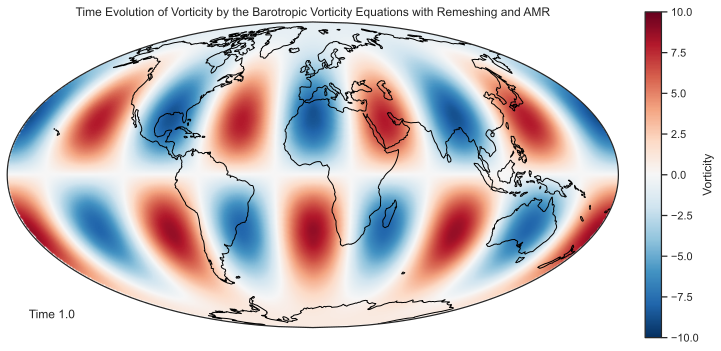

In [24]:
fig = plt.figure()
ax1  = plt.subplot(projection=ccrs.Mollweide())
ax1.coastlines()
ax1.set_global()
img = ax1.imshow(grid_z1, extent=np.degrees(extent_globe), cmap='RdBu_r', transform=ccrs.PlateCarree(), vmin=-10, vmax=10)
cbar = plt.colorbar(img, ax=ax1, fraction=0.046, pad=0.04)
cbar.set_label('Vorticity')
plt.title('Time Evolution of Vorticity by the Barotropic Vorticity Equations with Remeshing and AMR')
plt.figtext(0.15, 0.17, f'Time {1.00}')
# plt.show()
plt.savefig('bve_vor_t1_rh4.png')

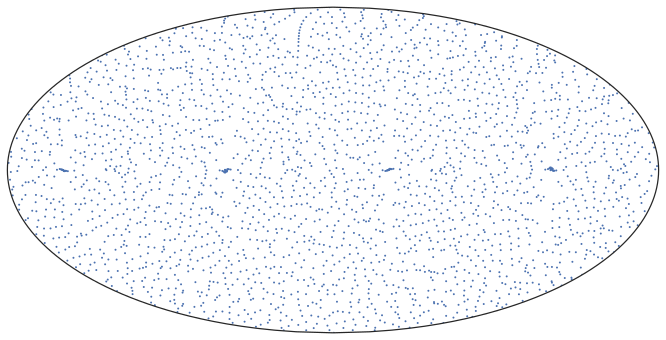

In [16]:
fig = plt.figure()
ax1  = plt.subplot(projection=ccrs.Mollweide())
# ax1.coastlines()
# ax1.set_global()
# img = ax1.imshow(spherical_triangulation, extent=np.degrees(extent_globe))
ax1.scatter(np.degrees(spherical_triangulation.lons), np.degrees(spherical_triangulation.lats), transform=ccrs.PlateCarree(), marker='o', lw=0, s=(144./fig.dpi)**2)
plt.show()
# plt.savefig('2562points_orthographic_disordered.png')

In [ ]:
np.rad2deg(spherical_triangulation.lons)

In [12]:
data[:,:,4].min()

-1.5708